In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Reading the Dataset
data=pd.read_csv('./input/with-grouping.csv')

In [3]:
from sklearn.decomposition import PCA
pca = PCA()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [4]:
# Importing all the requisite classifiers
from catboost import CatBoostClassifier as CBC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import Perceptron as PPT
from sklearn.tree import DecisionTreeClassifier as DTF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as NB

In [5]:
# Importing the ROC-AUC metric 
from sklearn.metrics import roc_curve,roc_auc_score

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

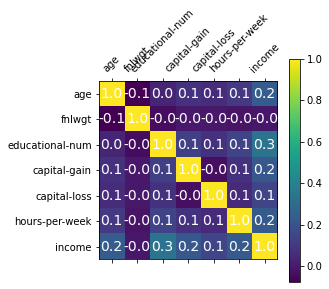

In [7]:
# Computing the correlation matrix of the numerical features with respect to the income. It is seen that the fnlwgt and income
# features are uncorrelated, hence fnlwgt is dropped.
plt.matshow(data.corr())
plt.colorbar()
plt.xticks(np.arange(len(data.corr().columns)), data.corr().columns.values, rotation = 45) 
plt.yticks(np.arange(len(data.corr().columns)), data.corr().columns.values) 
for (i, j), corr in np.ndenumerate(data.corr()):
    plt.text(j, i, '{:0.1f}'.format(corr), ha='center', va='center', color='white', fontsize=14)

In [8]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,dropout,7,NotMarried,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HighGrad,9,Married,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Government,336951,CommunityCollege,12,Married,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,CommunityCollege,10,Married,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,34,Private,198693,dropout,6,NotMarried,Other-service,Not-in-family,White,Male,0,0,30,United-States,0


In [9]:
# This function encodes all the categorical columns, which are hashable and comparable, with a value between 0 and n_classes-1
def FeatureEncoding(X_train,X_test):
    # The include parameter of describe is used to select features of a particular dtype. Here, categorical features are chosen
    categorical=X_train.describe(include='O').columns
    for feature in categorical:
        print('Encoding feature:',feature)
        le = preprocessing.LabelEncoder()
        # The dataset has already been split into training and testing datasets and they are both encoded. Encoding is done
        # separately so that there is no bias in the testing dataset that has passed on over from the training dataset.
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])
    return (X_train,X_test)

In [10]:
# This function scales and standardises all the features to a distribution with zero mean and unit standard deviation.
# In other words, features are standardized by removing their mean and scaling them to unit variance.
# z=(x-u)/s
def StandardScaling(X_train,X_test):
    scaler = StandardScaler()
    # Centering and scaling happen independently on each feature, and the relevant statistics are stored in the internal state
    # of the scaler for future use. They are called upon by using the transform feature
    
    # fit_transform computes the mean and standard deviation of the dataset, and then transform the features of the same dataset
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
    # The testing dataset is scaled according to the same statistics as those of the training dataset. This is because we want
    # the positions of the unlabelled test samples relative to our train dataset
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
    return (X_train, X_test)

In [11]:
def fit_and_predict(model,X_train,y_train,X_test,y_test):
    # For each model,
        #Fit the model to the training dataset
    model.fit(X_train,y_train)
        #Once fitted, apply the model to the test dataset and draw up predictions
    Y_prediction=model.predict(X_test)
        # Record the probability estimates of the classes(this is a binary class problem). Visually, it is the probability that
        # prediction lies on either side of the hyperplane
    Y_probs=model.predict_proba(X_test)
        #Discard the probability of class 0 since one leads to another by subtraction from 1
    Y_probs = Y_probs[:, 1]
    
        #Plot ROC and compute AUC score
    fpr,tpr,_=roc_curve(y_test,Y_probs)
    auc=roc_auc_score(y_test,Y_probs)
    
    ftpr.append((fpr,tpr,auc))
        #Record training and testing accuracies
    train_accuracy.append(model.score(X_train,y_train))
    test_accuracy.append(accuracy_score(y_test,Y_prediction))

In [12]:
def Classification(X_train,y_train,X_test,y_test):
    models=[]
    models.append(RFC(n_estimators=100))
    models.append(LR(max_iter=10000))
    models.append(KNN(n_neighbors=3))
    models.append(NB())
    models.append(SVC(kernel="linear",probability=True))
    models.append(DTF())
    models.append(CBC(learning_rate=0.04))
    #Fit the dataset for each of these classifiers: Random Forest, Logistic Regression, K-Nearest Neighbors, Kernelized Support 
    #Vector Machines, Decision Tree Classifier and CatBoost
    for i,model in enumerate(models):
        fit_and_predict(model,X_train,y_train,X_test,y_test)
        print(model,"done!")
        print("Training Accuracy:",train_accuracy[i])
        print("Test Accuracy:",test_accuracy[i])

In [13]:
# Represent the training and testing accuracies in the form of an easy-to-interpret table
def represent(train_accuracy,test_accuracy):
    results = pd.DataFrame({
        'Model': ['Random Forest','Logistic Regression','KNN(3)','Naive Bayes','Support Vector Machine', 'Decision Tree', 'Catboost'],
        'Training Score': train_accuracy,
        'Testing Score': test_accuracy})
    result_df = results.set_index('Model')
    print(result_df)

In [14]:
# Plot the Receiver Operating Characteristics for each of the classifiers with respect to the base classifier with no 
# disciminative/predictive power(TPR=FPR line)
def plotROC(ftpr):
    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr,ns_tpr,_=roc_curve(y_test,ns_probs)
    plt.figure(figsize=(10,10))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    labels=['Random Forest','Logistic Regression','KNN(n=3)','Naive Bayes','Support Vector Classifier','Decision Tree','Catboost']
    labels=iter(labels)
    for i in ftpr:
        plt.plot(i[0],i[1],marker='.', label='%s, %lf'%(next(labels),i[2]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [15]:
# Dropping the fnlwgt feature
dataset=data.copy()
data.drop(['fnlwgt'], axis = 1, inplace = True)

In [16]:
#Split the dataset into 70(train) - 30(test)
X = data.drop(['income'], axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [17]:
train_accuracy=[]
test_accuracy=[]
ftpr=[]

X_train,X_test=FeatureEncoding(X_train,X_test)
X_train,X_test=StandardScaling(X_train,X_test)
Classification(X_train,y_train,X_test,y_test)

Encoding feature: workclass
Encoding feature: education
Encoding feature: marital-status
Encoding feature: occupation
Encoding feature: relationship
Encoding feature: race
Encoding feature: gender
Encoding feature: native-country


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


RandomForestClassifier() done!
Training Accuracy: 0.9728320960353815
Test Accuracy: 0.841158693889585
LogisticRegression(max_iter=10000) done!
Training Accuracy: 0.838382561996525
Test Accuracy: 0.8264907496130316
KNeighborsClassifier(n_neighbors=3) done!
Training Accuracy: 0.8976149107565945
Test Accuracy: 0.8136655119038845
GaussianNB() done!
Training Accuracy: 0.798894329489812
Test Accuracy: 0.7876464951721088
SVC(kernel='linear', probability=True) done!
Training Accuracy: 0.8391091454746485
Test Accuracy: 0.8280386231296528
DecisionTreeClassifier() done!
Training Accuracy: 0.9728320960353815
Test Accuracy: 0.8110857227095157
0:	learn: 0.6505436	total: 113ms	remaining: 1m 52s
1:	learn: 0.6157881	total: 140ms	remaining: 1m 10s
2:	learn: 0.5818523	total: 175ms	remaining: 58.3s
3:	learn: 0.5535046	total: 204ms	remaining: 50.7s
4:	learn: 0.5278220	total: 231ms	remaining: 46s
5:	learn: 0.5045508	total: 257ms	remaining: 42.6s
6:	learn: 0.4837933	total: 283ms	remaining: 40.1s
7:	learn: 0.

In [18]:
represent(train_accuracy,test_accuracy)

                        Training Score  Testing Score
Model                                                
Random Forest                 0.972832       0.841159
Logistic Regression           0.838383       0.826491
KNN(3)                        0.897615       0.813666
Naive Bayes                   0.798894       0.787646
Support Vector Machine        0.839109       0.828039
Decision Tree                 0.972832       0.811086
Catboost                      0.888233       0.864524


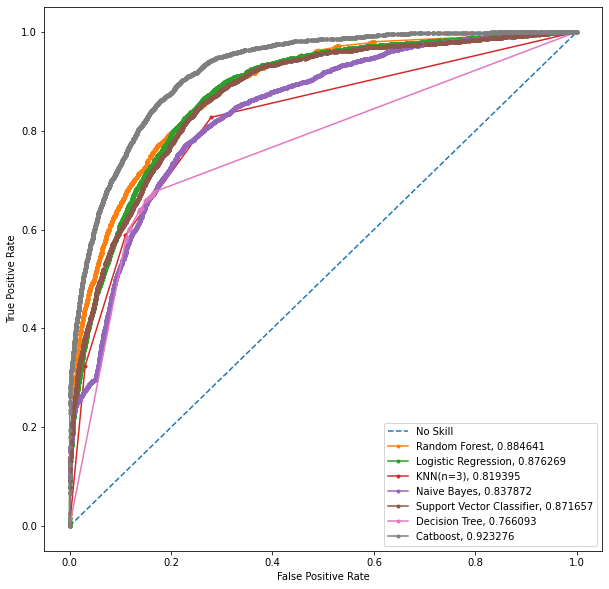

In [19]:
plotROC(ftpr)

In [20]:
# Apply the principal component analysis fit on the train dataset. The pca object stores the importance of each feature, aka the
# contribution of each feature to the total variance, into its internal state. We choose the first principal component as the 
# vector which captures the maximum variance of the data
X_train=pca.fit_transform(X_train)

In [21]:
# It is observed that the last two values contribute much less to the variance/spread of the data, so you could try removing 
# these feature entirely and examine if there's any significant reduction in the predicitive accuracy and AUC scores of the 
# classfiers.
np.cumsum(pca.explained_variance_ratio_)

array([0.17668316, 0.30418868, 0.38978106, 0.47393781, 0.55327596,
       0.62967279, 0.70306756, 0.7711781 , 0.83688185, 0.89986945,
       0.94219022, 0.97171132, 1.        ])

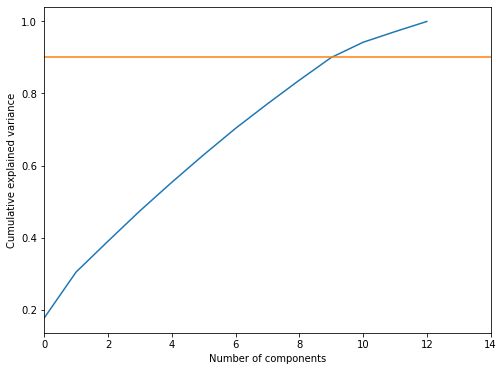

In [22]:
# Here's a cumulative plot for a better visual understanding of the description above.
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot([0,14],[0.9,0.9])
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [23]:
# Attempting to drop the last feature and computing the accuracies and AUC scores of the classifiers
X = data.drop(['income','native-country'], axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [25]:
train_accuracy=[]
test_accuracy=[]
ftpr=[]

X_train,X_test=FeatureEncoding(X_train,X_test)
X_train,X_test=StandardScaling(X_train,X_test)
Classification(X_train,y_train,X_test,y_test)

Encoding feature: workclass
Encoding feature: education
Encoding feature: marital-status
Encoding feature: occupation
Encoding feature: relationship
Encoding feature: race
Encoding feature: gender


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


RandomForestClassifier() done!
Training Accuracy: 0.9709366608750593
Test Accuracy: 0.8379892385936464
LogisticRegression(max_iter=10000) done!
Training Accuracy: 0.8380350655504659
Test Accuracy: 0.8268592909265129
KNeighborsClassifier(n_neighbors=3) done!
Training Accuracy: 0.8971094613805086
Test Accuracy: 0.8155082184712906
GaussianNB() done!
Training Accuracy: 0.7990522824198388
Test Accuracy: 0.7864671629689688
SVC(kernel='linear', probability=True) done!
Training Accuracy: 0.8389196019586164
Test Accuracy: 0.8276700818161716
DecisionTreeClassifier() done!
Training Accuracy: 0.9709366608750593
Test Accuracy: 0.8086533500405395
0:	learn: 0.6524602	total: 30.3ms	remaining: 30.2s
1:	learn: 0.6134229	total: 57.1ms	remaining: 28.5s
2:	learn: 0.5791029	total: 84.5ms	remaining: 28.1s
3:	learn: 0.5495893	total: 111ms	remaining: 27.7s
4:	learn: 0.5225833	total: 143ms	remaining: 28.5s
5:	learn: 0.5017993	total: 170ms	remaining: 28.2s
6:	learn: 0.4829548	total: 196ms	remaining: 27.8s
7:	lea

In [26]:
represent(train_accuracy,test_accuracy)

                        Training Score  Testing Score
Model                                                
Random Forest                 0.970937       0.837989
Logistic Regression           0.838035       0.826859
KNN(3)                        0.897109       0.815508
Naive Bayes                   0.799052       0.786467
Support Vector Machine        0.838920       0.827670
Decision Tree                 0.970937       0.808653
Catboost                      0.887253       0.863861


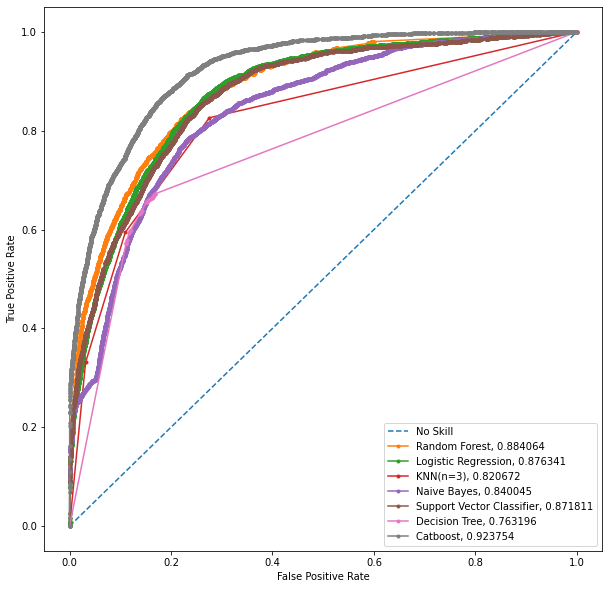

In [27]:
plotROC(ftpr)

In [28]:
# Dropping the last two features and recomputing AUC scores and accuracies
X = data.drop(['income','native-country','hours-per-week'], axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [29]:
train_accuracy=[]
test_accuracy=[]
ftpr=[]

X_train,X_test=FeatureEncoding(X_train,X_test)
X_train,X_test=StandardScaling(X_train,X_test)
Classification(X_train,y_train,X_test,y_test)

Encoding feature: workclass
Encoding feature: education
Encoding feature: marital-status
Encoding feature: occupation
Encoding feature: relationship
Encoding feature: race
Encoding feature: gender


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


RandomForestClassifier() done!
Training Accuracy: 0.937734954983415
Test Accuracy: 0.831355494950984
LogisticRegression(max_iter=10000) done!
Training Accuracy: 0.8366134891802243
Test Accuracy: 0.8262696248249429
KNeighborsClassifier(n_neighbors=3) done!
Training Accuracy: 0.8857684410045806
Test Accuracy: 0.8147711358443281
GaussianNB() done!
Training Accuracy: 0.7968409413994629
Test Accuracy: 0.7829291663595489
SVC(kernel='linear', probability=True) done!
Training Accuracy: 0.8250197441162533
Test Accuracy: 0.8154345102085944
DecisionTreeClassifier() done!
Training Accuracy: 0.937734954983415
Test Accuracy: 0.8177194663521781
0:	learn: 0.6543115	total: 29.3ms	remaining: 29.3s
1:	learn: 0.6172470	total: 61.6ms	remaining: 30.7s
2:	learn: 0.5831200	total: 92.8ms	remaining: 30.8s
3:	learn: 0.5558404	total: 121ms	remaining: 30.1s
4:	learn: 0.5319387	total: 153ms	remaining: 30.4s
5:	learn: 0.5074793	total: 179ms	remaining: 29.7s
6:	learn: 0.4877216	total: 205ms	remaining: 29.1s
7:	learn:

In [30]:
represent(train_accuracy,test_accuracy)

                        Training Score  Testing Score
Model                                                
Random Forest                 0.937735       0.831355
Logistic Regression           0.836613       0.826270
KNN(3)                        0.885768       0.814771
Naive Bayes                   0.796841       0.782929
Support Vector Machine        0.825020       0.815435
Decision Tree                 0.937735       0.817719
Catboost                      0.880240       0.861797


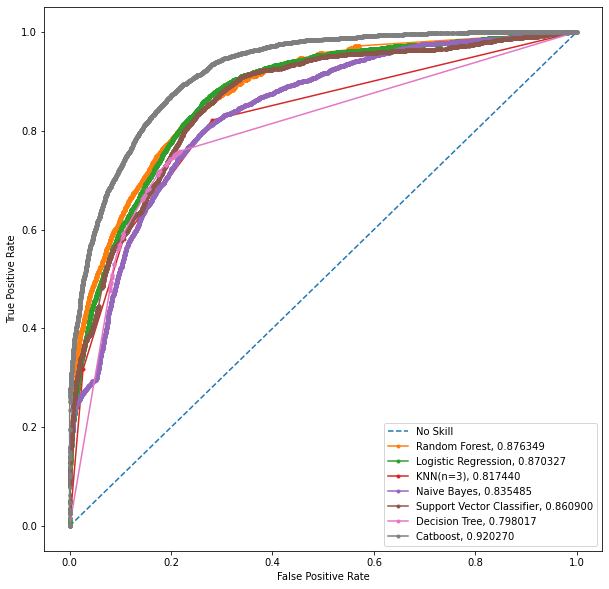

In [31]:
plotROC(ftpr)

It is observed that there is no significant reduction in the predictive powers of the classifiers even on removing the last 
two classifiers because the remaining 12 attributes still account for over 90% of the total variance in the data. Hence they
can be safely removed. 
It is also observed Yandex's Catboost, based on the advanced Gradient Descent - Boosting combination algorithm, outperforms 
all the other classifiers. Classifiers such as Decision tree do fit the training dataset considerably better than it, but 
they suffer from the overfitting that occur in the process and fare rather poorly on the test dataset.
The ROC-AUC score is the better metric for this dataset since it is a binary classification problem which is highly skewed to 
the <=50K class, which is the outcome of almost 75.22% of the data. Accuracy is a rather misleading metric when used here, and 
ROC-AUC curve helps balance the two classes by penalising the false positives that otherwise go unpunished in the accuracy 
calculation.